In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure GPU memory growth (optional, prevents errors on some GPUs)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [20]:
# Load the CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# One-hot encode the labels (10 classes) for training
y_train = to_categorical(y_train, 10)
y_test_encoded = to_categorical(y_test, 10) # Used for model evaluation

print(f"Training data shape: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Labels: {y_test_encoded.shape}")

Loading CIFAR-10 dataset...
Training data shape: (50000, 32, 32, 3), Labels: (50000, 10)
Test data shape: (10000, 32, 32, 3), Labels: (10000, 10)


In [21]:
# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,       # Rotate image by up to 15 degrees
    width_shift_range=0.1,   # Shift width by 10%
    height_shift_range=0.1,  # Shift height by 10%
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill missing pixels with nearest value
)

In [22]:
model = models.Sequential([
    # --- Block 1: Low-level features (Edges, Textures) ---
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2), # Low dropout for early layers

    # --- Block 2: Mid-level features (Shapes, Parts) ---
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # --- Block 3: High-level features (Objects, Complexity) ---
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4), # Higher dropout as parameters increase

    # --- Classifier ---
    layers.Flatten(),
    layers.Dense(128, activation='relu'), # Reduced dense size for efficiency
    layers.BatchNormalization(),
    layers.Dropout(0.5), # High dropout to prevent overfitting
    layers.Dense(10, activation='softmax')
])

# Define optimizer and compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [14]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_cifar10_model.keras", monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
]

# Start training
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=20,
    validation_data=(x_test, y_test_encoded),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.8202 - loss: 0.5325 - val_accuracy: 0.8425 - val_loss: 0.4743 - learning_rate: 2.5000e-04
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.8269 - loss: 0.5152 - val_accuracy: 0.8449 - val_loss: 0.4731 - learning_rate: 2.5000e-04
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.8281 - loss: 0.5049 - val_accuracy: 0.8468 - val_loss: 0.4569 - learning_rate: 2.5000e-04
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.8285 - loss: 0.5016 - val_accuracy: 0.8444 - val_loss: 0.4696 - learning_rate: 2.5000e-04
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.8340 - loss: 0.4968 - val_accuracy: 0.8542 - val_loss: 0.4413 - learning_rate: 2.5000e-04
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.8320 - loss: 0.4967 - val_accuracy: 0.8505 - val_loss: 0.4529 - learning_rate: 2.5000e-04
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/ste

In [16]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test_encoded, verbose=0)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

Final Test Accuracy: 85.96%
Final Test Loss: 0.4246


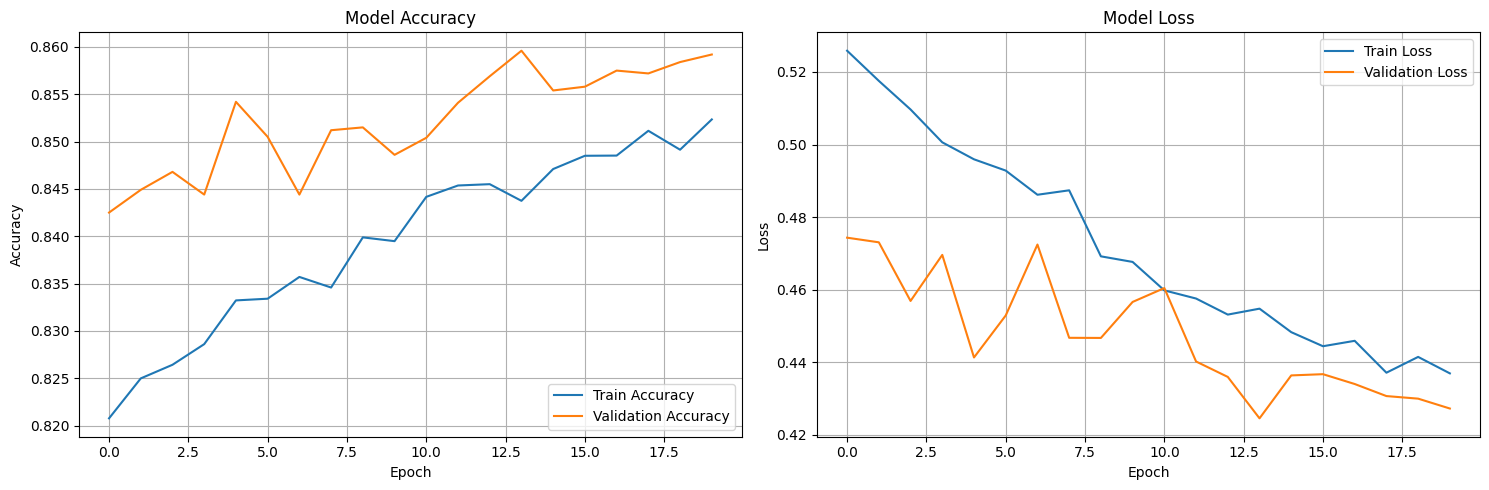

In [17]:
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


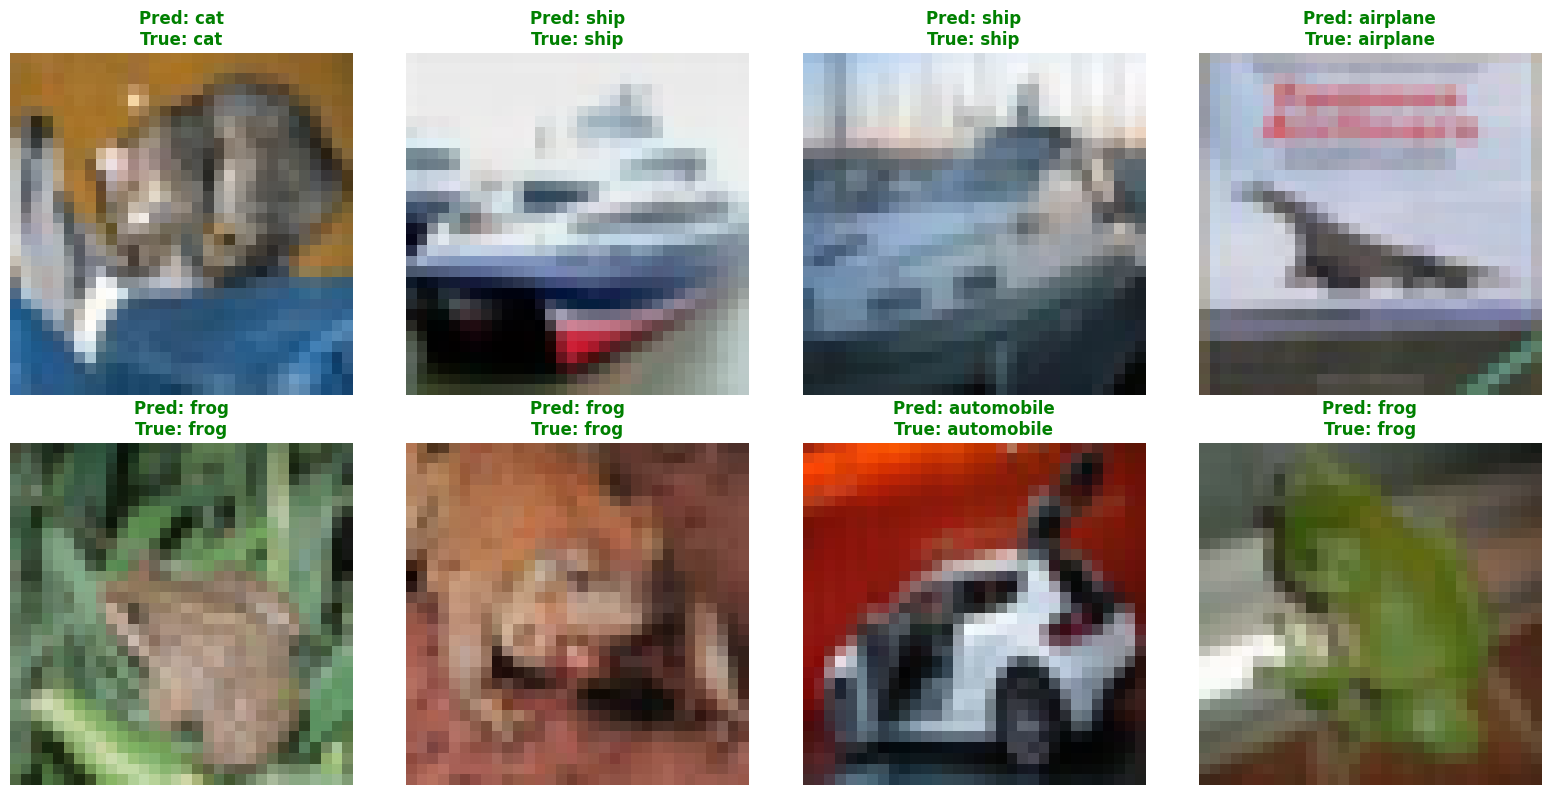

Project completed successfully.


In [18]:
# CIFAR-10 class labels
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Number of images to display
num_images = 8

# Get predictions on the first 8 test images
predictions = model.predict(x_test[:num_images])
predicted_classes = np.argmax(predictions, axis=1)

# Use original y_test labels (no argmax needed since we didn't overwrite y_test)
true_classes = y_test[:num_images].flatten()

# Plotting
plt.figure(figsize=(16, 8))

for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_test[i])

    # Logic: Green for correct, Red for wrong
    color = "green" if predicted_classes[i] == true_classes[i] else "red"

    plt.title(
        f"Pred: {class_names[predicted_classes[i]]}\n"
        f"True: {class_names[true_classes[i]]}",
        color=color,
        fontsize=12,
        fontweight='bold'
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

print("Project completed successfully.")